ROC and AUPR analysis

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix as cm
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt 
import ast
from sklearn import metrics
import matplotlib.ticker as plticker

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def str2list(arr):
    int_array = np.zeros((arr.shape[0], 3))
    for i, row in enumerate(arr):
        row = row.replace('[', '').replace(']', '')
        int_array[i] = np.fromstring(row, sep=' ')
    return int_array

In [47]:
def somaticTest_ROC(model):
    if model == "ecole-ft-somatic":
        ecole_predictions_path = "./ecole-ft-somatic_predictions_somatic_test/"
    elif model == "ecole":
        ecole_predictions_path = "./ecole_predictions_somatic_test/"
    else:
        raise ValueError('You have typed a wrong name for model name!')

    cur_dirname = os.getcwd()

    samples = [sample.split(".")[0] for sample in os.listdir(ecole_predictions_path)]

    preds_ = np.array([])
    wgs_preds_ = np.array([])
    probs_ = np.empty((0,3))

    for sample_name in tqdm(samples):
        
        ecole_calls_data = pd.read_csv(ecole_predictions_path + sample_name + ".csv", sep=",",header=None)
        wgs_calls_data = pd.read_csv(os.path.join(cur_dirname,f"../../../Groundtruths_exon_matched/Somatic_exon_matched_truths/Groundtruth_") + sample_name + ".vcf.csv", sep=",",header=None)
        new_df = pd.merge(wgs_calls_data, ecole_calls_data,  how='left', left_on=[0,1,2], right_on = [0,1,2]).values
        wgs_preds_n = np.array(new_df[:,3]) 
        wgs_preds_ = np.append(wgs_preds_,wgs_preds_n)
        preds_n= np.array(new_df[:,4]) 
        preds_ = np.append(preds_,preds_n)
        probs_n = str2list(new_df[:,5])
        probs_ = np.append(probs_,probs_n,axis=0)
        
            
    wgs_preds_[wgs_preds_ == "<DEL>"] = 2
    wgs_preds_[wgs_preds_ == "<DUP>"] = 1
    wgs_preds_[wgs_preds_ == "<NO-CALL>"] = 0
    wgs_preds_ = wgs_preds_.astype(int)

    print("DEL AUC Score: "+str(metrics.roc_auc_score(wgs_preds_==2,probs_[:,2])))
    print("DUP AUC Score: "+str(metrics.roc_auc_score(wgs_preds_==1,probs_[:,1])))
    del_fpr, del_tpr, del_thresholds = metrics.roc_curve(wgs_preds_, probs_[:,2], pos_label=2)
    dup_fpr, dup_tpr, dup_thresholds = metrics.roc_curve(wgs_preds_, probs_[:,1], pos_label=1)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    ax1.plot(del_fpr,del_tpr)
    ax1.set_title("DEL ROC Curve"+' ('+model+')')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    ax2.plot(dup_fpr,dup_tpr)
    ax2.set_title("DUP ROC Curve"+' ('+model+')')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')
    plt.show()

In [46]:
def somaticTest_AUPR(model):
    if model == "ecole-ft-somatic":
        ecole_predictions_path = "./ecole-ft-somatic_predictions_somatic_test/"
    elif model == "ecole":
        ecole_predictions_path = "./ecole_predictions_somatic_test/"
    else:
        raise ValueError('You have typed a wrong name for model name!')

    cur_dirname = os.getcwd()

    samples = [sample.split(".")[0] for sample in os.listdir(ecole_predictions_path)]

    preds_ = np.array([])
    wgs_preds_ = np.array([])
    probs_ = np.empty((0,3))

    for sample_name in tqdm(samples):
        
        ecole_calls_data = pd.read_csv(ecole_predictions_path + sample_name + ".csv", sep=",",header=None)
        wgs_calls_data = pd.read_csv(os.path.join(cur_dirname,f"../../../Groundtruths_exon_matched/Somatic_exon_matched_truths/Groundtruth_") + sample_name + ".vcf.csv", sep=",",header=None)
        new_df = pd.merge(wgs_calls_data, ecole_calls_data,  how='left', left_on=[0,1,2], right_on = [0,1,2]).values
        wgs_preds_n = np.array(new_df[:,3]) 
        wgs_preds_ = np.append(wgs_preds_,wgs_preds_n)
        preds_n= np.array(new_df[:,4]) 
        preds_ = np.append(preds_,preds_n)
        probs_n = str2list(new_df[:,5])
        probs_ = np.append(probs_,probs_n,axis=0)
        
            
    wgs_preds_[wgs_preds_ == "<DEL>"] = 2
    wgs_preds_[wgs_preds_ == "<DUP>"] = 1
    wgs_preds_[wgs_preds_ == "<NO-CALL>"] = 0
    wgs_preds_ = wgs_preds_.astype(int)

    print("DEL AUPR Score: "+str(metrics.average_precision_score(wgs_preds_==2,probs_[:,2])))
    print("DUP AUPR Score: "+str(metrics.average_precision_score(wgs_preds_==1,probs_[:,1])))
    del_prec, del_recall, del_thresholds = metrics.precision_recall_curve(wgs_preds_==2,probs_[:,2])
    dup_prec, dup_recall, dup_thresholds = metrics.precision_recall_curve(wgs_preds_==1,probs_[:,1])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8),sharey=True)
    

    plt.rcParams["figure.figsize"] = [8,8]
    plt.rcParams["figure.autolayout"] = True
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("DEL Precision-Recall Curve"+' ('+model+')')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.plot(del_recall, del_prec)
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    ax2.plot(dup_recall,dup_prec)
    ax2.set_title("DUP Precision-Recall Curve"+' ('+model+')')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    plt.show()

    plt.show()

In [4]:
def somaticTest_AUPR_v2(model):
    if model == "ecole-ft-somatic":
        ecole_predictions_path = "./ecole-ft-somatic_predictions_somatic_test/"
    elif model == "ecole":
        ecole_predictions_path = "./ecole_predictions_somatic_test/"
    else:
        raise ValueError('You have typed a wrong name for model name!')

    cur_dirname = os.getcwd()

    samples = [sample.split(".")[0] for sample in os.listdir(ecole_predictions_path)]

    preds_ = np.array([])
    wgs_preds_ = np.array([])
    probs_ = np.empty((0,3))

    for sample_name in tqdm(samples):
        
        ecole_calls_data = pd.read_csv(ecole_predictions_path + sample_name + ".csv", sep=",",header=None)
        wgs_calls_data = pd.read_csv(os.path.join(cur_dirname,f"../../../Groundtruths_exon_matched/Somatic_exon_matched_truths/Groundtruth_") + sample_name + ".vcf.csv", sep=",",header=None)
        new_df = pd.merge(wgs_calls_data, ecole_calls_data,  how='left', left_on=[0,1,2], right_on = [0,1,2]).values
        wgs_preds_n = np.array(new_df[:,3]) 
        wgs_preds_ = np.append(wgs_preds_,wgs_preds_n)
        preds_n= np.array(new_df[:,4]) 
        preds_ = np.append(preds_,preds_n)
        probs_n = str2list(new_df[:,5])
        probs_ = np.append(probs_,probs_n,axis=0)
        
            
    wgs_preds_[wgs_preds_ == "<DEL>"] = 2
    wgs_preds_[wgs_preds_ == "<DUP>"] = 1
    wgs_preds_[wgs_preds_ == "<NO-CALL>"] = 0
    wgs_preds_ = wgs_preds_.astype(int)

    class_counts = dict()
    precision = dict()
    recall = dict()
    precision["DEL"], recall["DEL"], del_thresholds = metrics.precision_recall_curve(wgs_preds_==2,probs_[:,2])
    precision["DUP"], recall["DUP"], dup_thresholds = metrics.precision_recall_curve(wgs_preds_==1,probs_[:,1])

    class_counts["DEL"] = np.sum(wgs_preds_==2)
    class_counts["DUP"] = np.sum(wgs_preds_==1)
    # Interpolate the precision and recall values to a common set of thresholds
    common_thresholds = np.linspace(0, 1, 100)
    for cv_type in ["DEL","DUP"]:
        precision[cv_type] = np.interp(common_thresholds, recall[cv_type][::-1], precision[cv_type][::-1])
        recall[cv_type] = common_thresholds

    macro_precision = np.average(list(precision.values()), axis=0)
    macro_recall = np.average(list(recall.values()), axis=0)

    fig, ax = plt.subplots(figsize =(5, 5))
        
    ax.set_title("The Macro Average Precision-Recall Curve")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    plt.rcParams["figure.autolayout"] = True
    ax.plot(macro_recall, macro_precision)
    plt.show()

100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


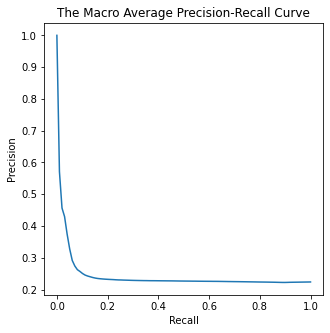

In [5]:
somaticTest_AUPR_v2("ecole")

100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


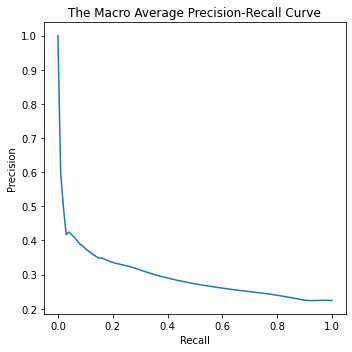

In [6]:
somaticTest_AUPR_v2("ecole-ft-somatic")

100%|██████████| 13/13 [00:31<00:00,  2.44s/it]


DEL AUC Score: 0.5652436602776617
DUP AUC Score: 0.48689137809067407


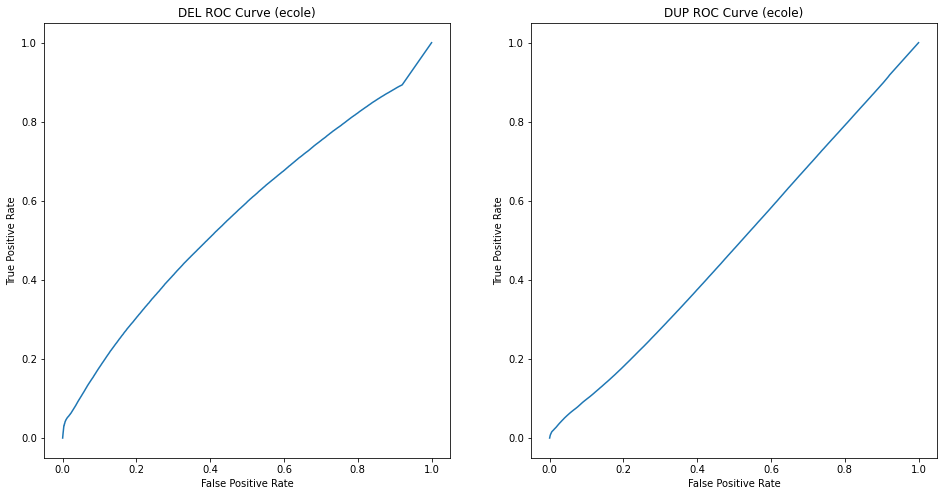

100%|██████████| 13/13 [00:31<00:00,  2.46s/it]


DEL AUC Score: 0.6602784611726753
DUP AUC Score: 0.5529812075708603


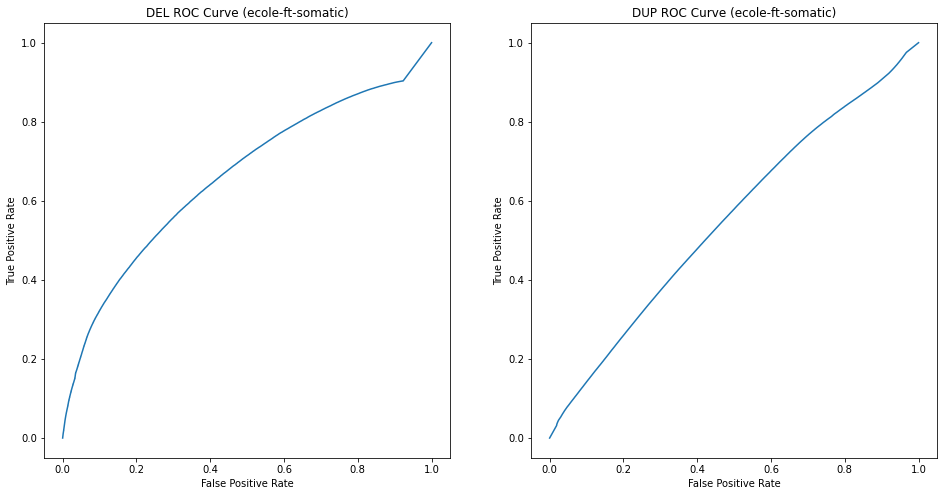

In [23]:
somaticTest_ROC("ecole")
somaticTest_ROC("ecole-ft-somatic")

100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


DEL AUPR Score: 0.09427523437873611
DUP AUPR Score: 0.3887731886814205


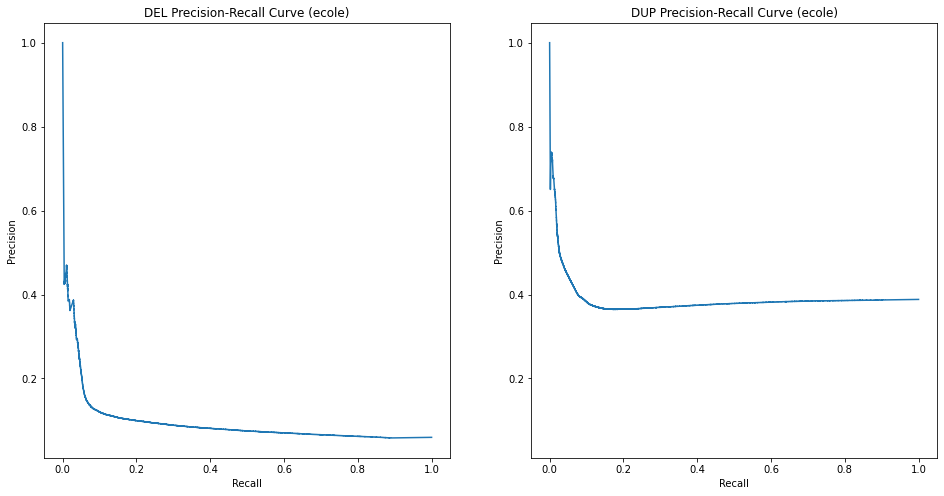

100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


DEL AUPR Score: 0.14230608431858305
DUP AUPR Score: 0.43621401995098724


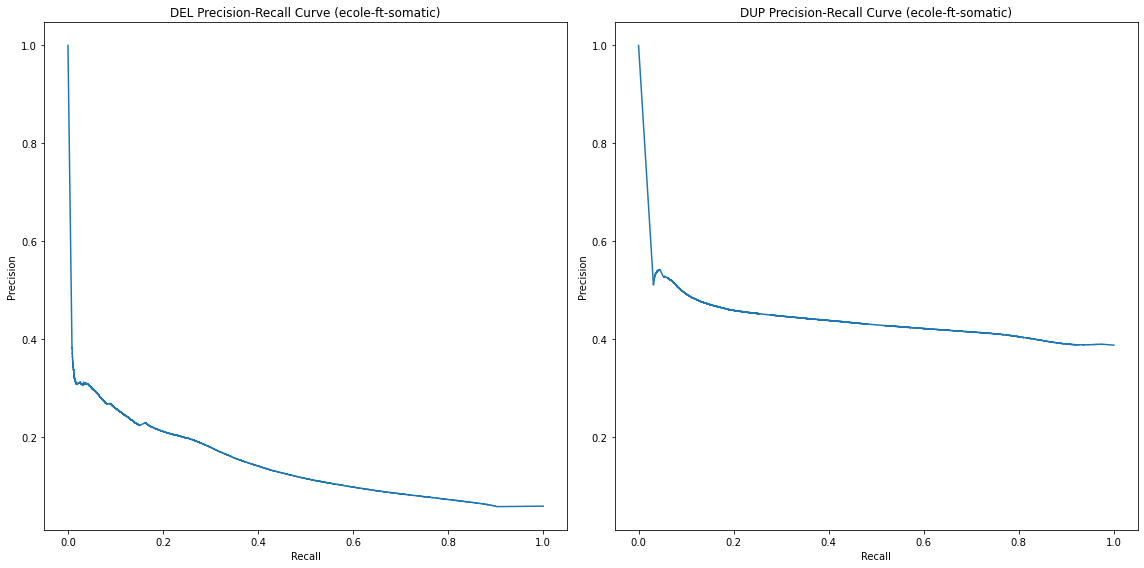

In [50]:
somaticTest_AUPR("ecole")
somaticTest_AUPR("ecole-ft-somatic")

ValueError: x is neither increasing nor decreasing : [1.         0.98863636 0.98863636 0.98863636 0.97727273 0.97727273
 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273
 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273
 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273
 0.96590909 0.96590909 0.95454545 0.94318182 0.93181818 0.92045455
 0.92045455 0.92045455 0.90909091 0.90909091 0.89772727 0.89772727
 0.88636364 0.88636364 0.875      0.875      0.86363636 0.86363636
 0.86363636 0.86363636 0.85227273 0.84090909 0.82954545 0.82954545
 0.82954545 0.82954545 0.81818182 0.80681818 0.80681818 0.79545455
 0.78409091 0.77272727 0.76136364 0.75       0.75       0.73863636
 0.72727273 0.71590909 0.70454545 0.69318182 0.69318182 0.69318182
 0.69318182 0.68181818 0.67045455 0.65909091 0.65909091 0.64772727
 0.63636364 0.63636364 0.63636364 0.625      0.625      0.61363636
 0.60227273 0.60227273 0.60227273 0.59090909 0.57954545 0.56818182
 0.55681818 0.55681818 0.54545455 0.53409091 0.52272727 0.51136364
 0.5        0.48863636 0.47727273 0.46590909 0.45454545 0.44318182
 0.43181818 0.42045455 0.40909091 0.39772727 0.38636364 0.375
 0.36363636 0.36363636 0.35227273 0.34090909 0.32954545 0.31818182
 0.31818182 0.30681818 0.29545455 0.28409091 0.28409091 0.27272727
 0.26136364 0.25       0.23863636 0.22727273 0.21590909 0.20454545
 0.20454545 0.19318182 0.18181818 0.17045455 0.15909091 0.14772727
 0.13636364 0.125      0.11363636 0.10227273 0.09090909 0.07954545
 0.06818182 0.05681818 0.04545455 0.03409091 0.02272727 0.01136364
 0.         0.         1.         0.98863636 0.98863636 0.98863636
 0.98863636 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273
 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273
 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273 0.97727273
 0.97727273 0.97727273 0.96590909 0.96590909 0.96590909 0.95454545
 0.94318182 0.93181818 0.92045455 0.92045455 0.92045455 0.92045455
 0.90909091 0.89772727 0.88636364 0.88636364 0.88636364 0.88636364
 0.875      0.86363636 0.86363636 0.86363636 0.86363636 0.85227273
 0.84090909 0.82954545 0.82954545 0.82954545 0.82954545 0.81818182
 0.81818182 0.80681818 0.79545455 0.78409091 0.77272727 0.76136364
 0.75       0.75       0.73863636 0.72727273 0.71590909 0.70454545
 0.69318182 0.69318182 0.69318182 0.69318182 0.68181818 0.67045455
 0.65909091 0.65909091 0.64772727 0.64772727 0.63636364 0.63636364
 0.625      0.625      0.61363636 0.60227273 0.60227273 0.60227273
 0.59090909 0.57954545 0.56818182 0.55681818 0.55681818 0.54545455
 0.53409091 0.52272727 0.51136364 0.5        0.48863636 0.47727273
 0.46590909 0.45454545 0.44318182 0.43181818 0.42045455 0.40909091
 0.39772727 0.38636364 0.375      0.36363636 0.36363636 0.35227273
 0.34090909 0.32954545 0.31818182 0.31818182 0.30681818 0.29545455
 0.28409091 0.28409091 0.27272727 0.26136364 0.25       0.23863636
 0.22727273 0.21590909 0.20454545 0.20454545 0.19318182 0.18181818
 0.17045455 0.15909091 0.14772727 0.13636364 0.125      0.11363636
 0.10227273 0.09090909 0.07954545 0.06818182 0.05681818 0.04545455
 0.03409091 0.02272727 0.01136364 0.         0.        ].